# 📈 LSTM Forecasting - Daily Minimum Temperatures

Epoch 1, Loss: 0.041114


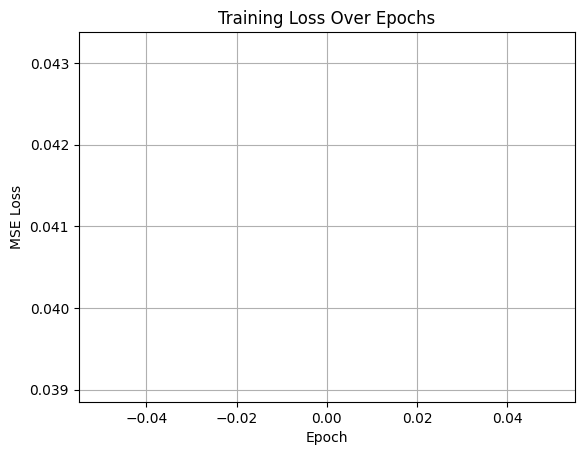

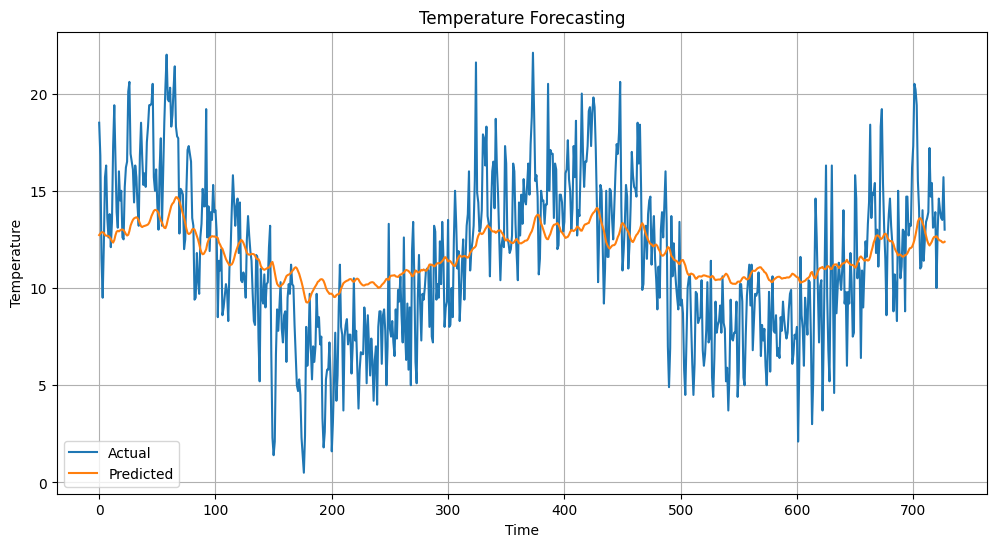

In [ ]:

# 🧠 LSTM Time Series Forecasting - Daily Minimum Temperatures

## 1. Imports and Dataset Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Load data, df is  just the dataframe with all the data
df = pd.read_csv("daily-min-temperatures.csv")
# print('df',df)
# This line gets the temperatures values in a numpy array and reshapes it in a 2D array 
# with 1 column and as many rows as needed "-1" 
temps = df["Temp"].values.reshape(-1, 1)
# print('temps',temps)

# Normalize
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(temps)
# print(temps_scaled)

#data = [1, 2, 3, 4, 5, 6] and seq_length = 3
#Input x	Output y
#[1, 2, 3]	  4
#[2, 3, 4]    5
#[3, 4, 5]	  6
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10
X, y = create_sequences(temps_scaled, SEQ_LENGTH)

# X contains the temp values from the 10 days before a target day, which temperature value
# is contained inside the y array
# So, at a specific position inside X, for example X[0] there is an array containing 10
#  temperatures values, used by the model to train, with a prediction value which is contained
#inside the same place in y, y[0]

# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## 2. PyTorch Dataset
class TempDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TempDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TempDataset(X_test, y_test), batch_size=32)

## 3. LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=50, num_layers=1):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])
#         return out
    
#Slightly improved model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # take only the last time step
        out = torch.relu(self.fc1(out))
        return self.fc2(out)


model = LSTMModel()

## 4. Training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 30

train_losses = []



for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

## 5. Evaluation and Prediction
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        predictions.extend(y_pred.numpy())
        actuals.extend(y_batch.numpy())

# Inverse scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Temperature Forecasting")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()
